In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests as req
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#zapytanie SQL zapisane w postaci zmiennej tekstopwej query1

query1 = """SELECT 
  EXTRACT(YEAR FROM creation_date) AS Year,
  COUNT(*) AS Number_of_Questions,
  SUM(answer_count) AS Number_of_Answers

FROM
  `bigquery-public-data.stackoverflow.posts_questions`
GROUP BY
  Year
HAVING
  Year > 2008 AND Year <= 2018
ORDER BY
  Year
 ; """

In [0]:
# jednorazowo będzie potrzebne podanie kodu weryfikacyjnego
df = pd.read_gbq(query = query1, project_id = '66140242391', dialect = 'standard')


In [0]:
df.head()

,Year,Number_of_Questions,Number_of_Answers
0,2009,343139,1148668
1,2010,693332,1722921
2,2011,1198587,2532982
3,2012,1642687,3008800
4,2013,2056613,3407852


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
Year                   10 non-null int64
Number_of_Questions    10 non-null int64
Number_of_Answers      10 non-null int64
dtypes: int64(3)
memory usage: 320.0 bytes


In [0]:
df.Year.unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

# How did the number of question varied with time over the years ?

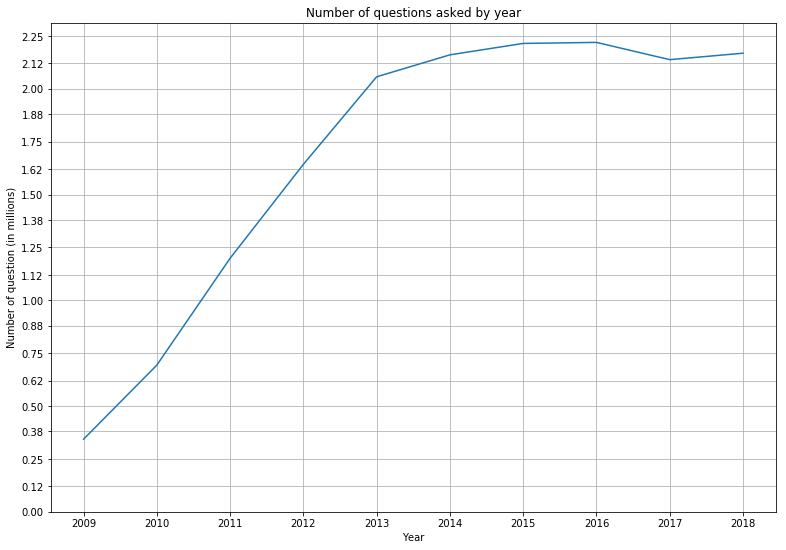

In [0]:
dates_xaxis=[y for y in df.Year]
num_ques_mln_yaxis=[noq/1000000 for noq in df.Number_of_Questions]
plt.figure(figsize=(13,9))
plt.plot(dates_xaxis,num_ques_yaxis)
plt.xlabel('Year')
plt.ylabel('Number of question (in millions)')
plt.title('Number of questions asked by year')
plt.xticks([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.yticks([round(yt/8,2) for yt in range(19)])
plt.grid(b=True)
plt.show()

We can see that the number of questions in 2018 was rougly 6 times more than in 2009.

# How does the number of answers per 1 question evolves through time ?

This can be a proxy for measuring users activity. It seems that the more people answers questions,the more active the community.

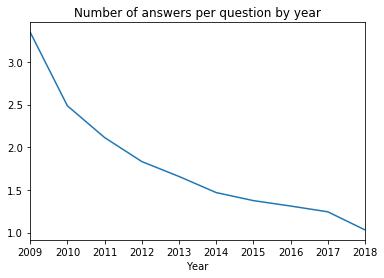

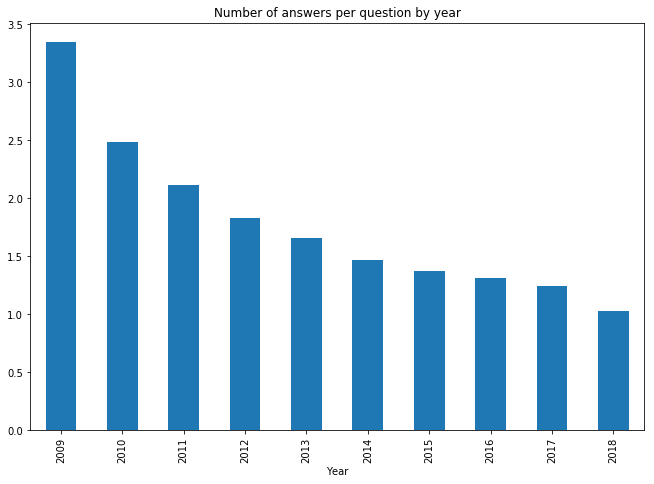

In [0]:
df['Answers_per_Question']=[noa/noq for noa,noq in zip(df.Number_of_Answers,df.Number_of_Questions)]
df.groupby('Year')['Answers_per_Question'].sum().plot()
plt.title('Number of answers per question by year')
plt.show()
plt.figure(figsize=(11,7.5))
df.groupby('Year')['Answers_per_Question'].sum().plot(kind='bar')
plt.title('Number of answers per question by year')
plt.show()

In [0]:
df['Answers_per_Question']

0    3.347530
1    2.484987
2    2.113307
3    1.831633
4    1.657022
5    1.468124
6    1.374069
7    1.310259
8    1.242778
9    1.030479
Name: Answers_per_Question, dtype: float64

We can see that the number of answers per questions in 2018 is roughly 3 times less than in 2009.
This suggest either less users activity or, perhaps,that moderators are doing better job at removing duplicated or bad quality answers.
 

The number of answers per question in 2018 is barely more than 1 - 1.03, and hence we can suspect that some questions went unanswered.

# What fraction of answers offers the exactly right solution to the problem ?

On stackoverflow when the answer is accepted it means that the person who posed the question have marked it as the one which solves their problem most effectively.
One don't have to accept any answer.
(https://stackoverflow.com/help/someone-answers)

In [0]:
#zapytanie SQL zapisane w postaci zmiennej tekstopwej query2

query2 = """SELECT COUNT(accepted_answer_id) AS Fully_Answered_Questions,
  EXTRACT(YEAR FROM creation_date) AS Year,
  COUNT(*) AS Number_of_Questions,
  SUM(answer_count) AS Number_of_Answers

FROM
  `bigquery-public-data.stackoverflow.posts_questions`
GROUP BY
  Year
HAVING
  Year > 2008 AND Year <= 2018
ORDER BY
  Year; """

In [0]:
df2 = pd.read_gbq(query = query2, project_id = '66140242391', dialect = 'standard')

In [0]:
df2.head()

,Fully_Answered_Questions,Year,Number_of_Questions,Number_of_Answers
0,250297,2009,343139,1148668
1,495828,2010,693332,1722921
2,823894,2011,1198587,2532982
3,1063072,2012,1642687,3008800
4,1172818,2013,2056613,3407852


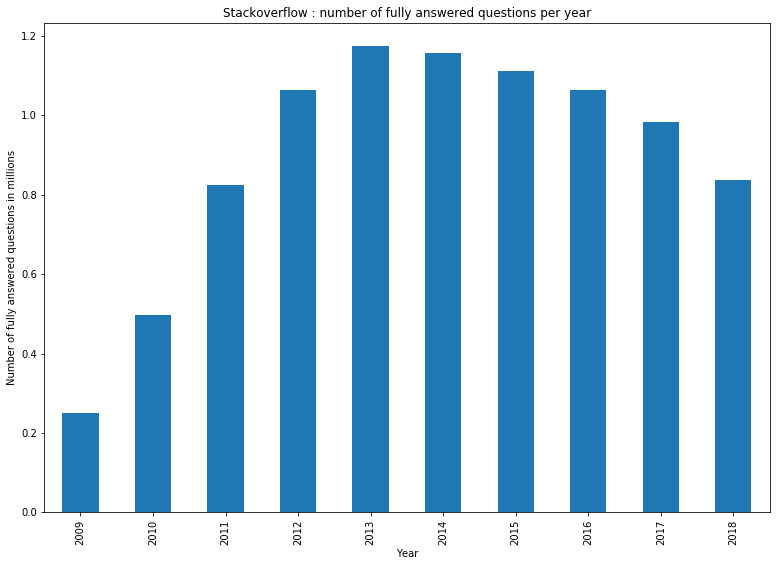

In [0]:
plt.figure(figsize=(13,9))
df2.groupby('Year')['Fully_Answered_Questions'].sum().div(1000000).plot(kind='bar')
plt.title('Stackoverflow : number of fully answered questions per year')
plt.ylabel('Number of fully answered questions in millions')
plt.show()

We can see that the number of fully answered questions in 2018 is about 3.5 times what it was in 2009.
The growth is therefore slower than the growth of number of questions in general, which was around 6 times for the same period.
Since the number of great answers is lagging behind the number of questions we can conclude that the quality of answers deteriorated between 2009 and 2018.

In [0]:
df2['% great answers']=[100*(faq/noq) for faq,noq in zip(df2.Fully_Answered_Questions,df2.Number_of_Questions)]
df2

,Fully_Answered_Questions,Year,Number_of_Questions,Number_of_Answers,% great answers
0,250297,2009,343139,1148668,72.943326
1,495828,2010,693332,1722921,71.513791
2,823894,2011,1198587,2532982,68.738773
3,1063072,2012,1642687,3008800,64.715433
4,1172818,2013,2056613,3407852,57.026674
5,1156325,2014,2160361,3171678,53.524619
6,1110554,2015,2214389,3042724,50.151712
7,1062314,2016,2219199,2907726,47.869254
8,981702,2017,2137687,2656670,45.923561
9,836234,2018,2168086,2234168,38.570149


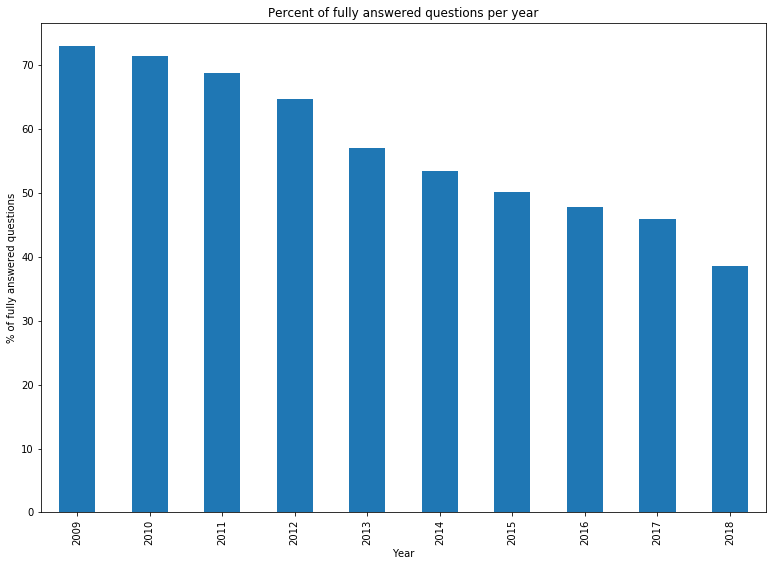

In [0]:
plt.figure(figsize=(13,9))
df2.groupby('Year')['% great answers'].sum().plot(kind='bar')
plt.ylabel('% of fully answered questions')
plt.title('Percent of fully answered questions per year')
plt.show()

We can see that since 2009 the fraction of the really good answers is on the steady decline, from 73 % in 2009 to as low as 39 % in 2018.

# What are the technologies or problems which generates the most questions ?

In [0]:
query3="""SELECT tag_name,count
FROM `bigquery-public-data.stackoverflow.tags`
;"""

In [0]:
df3=pd.read_gbq(query = query3, project_id = '66140242391', dialect = 'standard')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=495642085510-k0tmvj2m941jhre2nbqka17vqpjfddtd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=ahCXX8ikFNTmualTANN83YbxCI4bhN&prompt=consent&access_type=offline
Enter the authorization code: 4/VwFNLpVkXgDv8V7liZZdGwBTsJQfxhYbN_F9XuZUv9hTjMubIKJAsQE


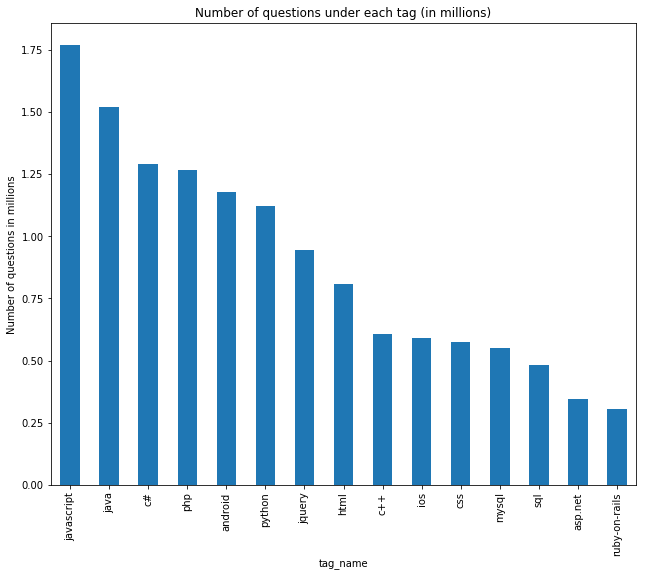

In [0]:
plt.figure(figsize=(10.5,8.5))
df3.groupby('tag_name')['count'].sum().sort_values(ascending=False).head(15).div(1000000).plot(kind='bar')
plt.title('Number of questions under each tag (in millions)')
plt.ylabel('Number of questions in millions')
plt.show()

# What are the questions related to Python about ?

In [0]:
query4="""SELECT a.id, a.body, a.owner_user_id
        FROM `bigquery-public-data.stackoverflow.posts_answers` AS a
        INNER JOIN `bigquery-public-data.stackoverflow.posts_questions` AS q
        ON a.parent_id = q.id
        WHERE q.tags LIKE '%ython%'
        LIMIT 4000;"""

In [0]:
df4=pd.read_gbq(query = query4, project_id = '66140242391', dialect = 'standard')

In [0]:
for text in df4.body.head(20):
  print(text)

<p>Would a <a href="http://groups.google.com/group/google-appengine/browse_thread/thread/80d0c2351fe2fdf8" rel="nofollow">solution</a> using cursors (like the one below) work for you? I personally use this method to count the number of entries in a scenario similar to yours, and haven't seen yet any problems with it (although I run on a schedule, since constant querying of the data store is pretty taxing on the CPU quota).</p>

<pre><code>def count(query): 
  i = 0 
  while True: 
    result = query.fetch(1000) 
    i = i + len(result) 
    if len(result) &lt; 1000: 
      break 
    cursor = query.cursor() 
    query.with_cursor(cursor) 
  return i 
</code></pre>
<p>Expanding on <a href="https://stackoverflow.com/users/3089523/bin">Bin</a>'s answer:</p>

<pre><code>import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By 

In [0]:
text=' '.join(df4.body.tolist())

In [0]:
# Creating a BeautifulSoup object from the HTML
soup = bs(text,"html.parser")

In [0]:
# Extracting the list of paragraphs of the article
results=soup.find_all('p')

# removing some paragraphs without text
better_results=[]
for r in results:
    if not (str(r)[:5]=='<p><a'):
        better_results.append(str(r))

In [0]:
# transforming our list of paragraphs into single text
text=' '.join(better_results)

In [0]:
def cleanhtml(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext

clean_text=cleanhtml(text)

In [0]:
# Creating a tokenizer
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+|\.')

# Tokenizing the text
tokens = tokenizer.tokenize(clean_text)

In [0]:
# getting a list of proper nouns to remove (words like Python)
proper_nouns=[]

for t in tokens:
    if (tokens[(tokens.index(t)-1)]!='.') & ((t.capitalize()==t) | (t.isupper())):
        proper_nouns.append(t)
        

In [0]:
# getting list of english stopwords,that is,words like am,you etc.
stopwords=stopwords.words('english')

# removing stopwords and converting all words to lowercase and removing proper nouns
words=[t.lower() for t in tokens if (t.lower() not in stopwords) & (t.upper() not in proper_nouns) & (t.lower()!='python')]

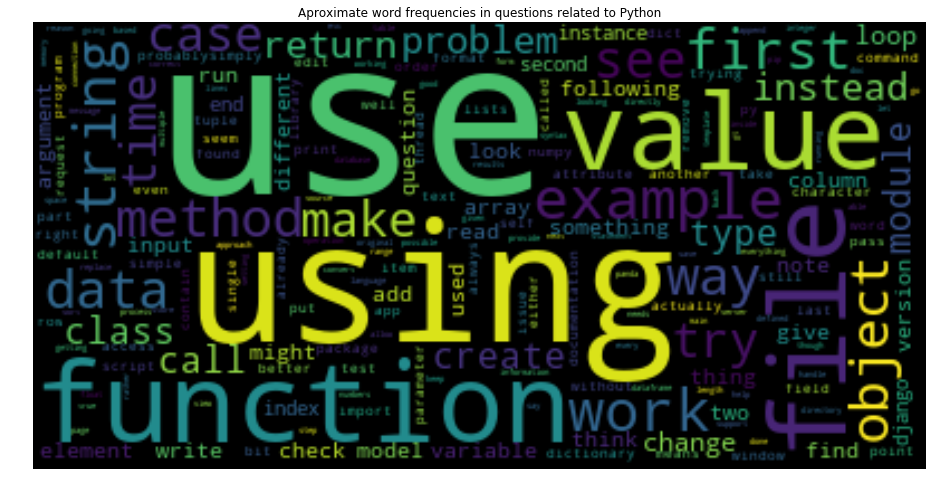

In [0]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(words))

# Display the generated image:
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Aproximate word frequencies in questions related to Python')
plt.axis("off")
plt.show()

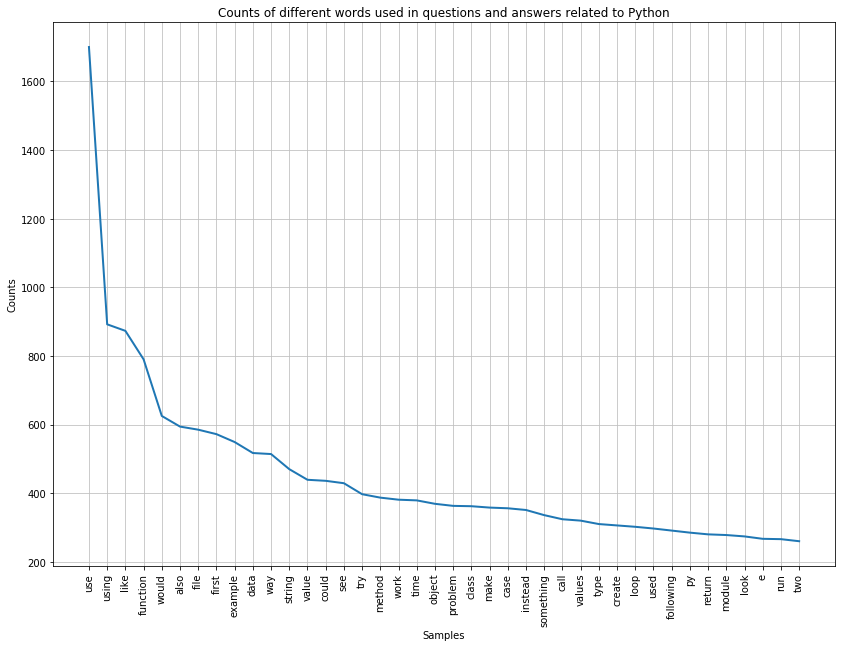

In [0]:
# Creating the word frequency distribution
freqdist = nltk.FreqDist(words)

# Plotting the word frequency distribution
plt.figure(figsize=(14,10))
freqdist.plot(40,title='Counts of different words used in questions and answers related to Python')


plt.show()

# Pandas was brought to life in 2008. What was the dynamics of the number of questions related to pandas since then ?

In [0]:
query5="""SELECT q.tags,EXTRACT(YEAR FROM q.creation_date) AS Year,
          COUNT(*) AS Number_of_Questions,
          SUM(q.answer_count) AS Number_of_Answers
          FROM `bigquery-public-data.stackoverflow.posts_answers` AS a
          INNER JOIN `bigquery-public-data.stackoverflow.posts_questions` AS q
          ON a.parent_id = q.id
          WHERE q.tags LIKE '%pandas%'
          GROUP BY
          Year,q.tags
          HAVING
          Year > 2008 AND Year <= 2018
          ORDER BY
          Year
          ;"""

In [0]:
df5=pd.read_gbq(query = query5, project_id = '66140242391', dialect = 'standard')

In [0]:
df5=df5.dropna()

In [0]:
# removing some entries related to java or javascript
df5['tags']=df5['tags'].apply(lambda x:np.nan if x[:3]=='jav' else x)

In [0]:
# removing pandastream
df5['tags']=df5['tags'].apply(lambda x:np.nan if 'pandastream' in ''.join(x) else x)

TypeError: ignored

In [0]:
df5.head()

,tags,Year,Number_of_Questions,Number_of_Answers
3,python|compiler-errors|install|pandas,2011,2,4
4,file-upload|heroku|pandastream,2011,1,1
5,python|pandas,2011,3,5
6,python|r|numpy|pandas|data.table,2011,1,1
7,python|finance|quantitative-finance|pandas,2011,3,9


In [0]:
df5=df5.dropna()

In [0]:
df5.isnull().sum()

tags                   0
Year                   0
Number_of_Questions    0
Number_of_Answers      0
dtype: int64

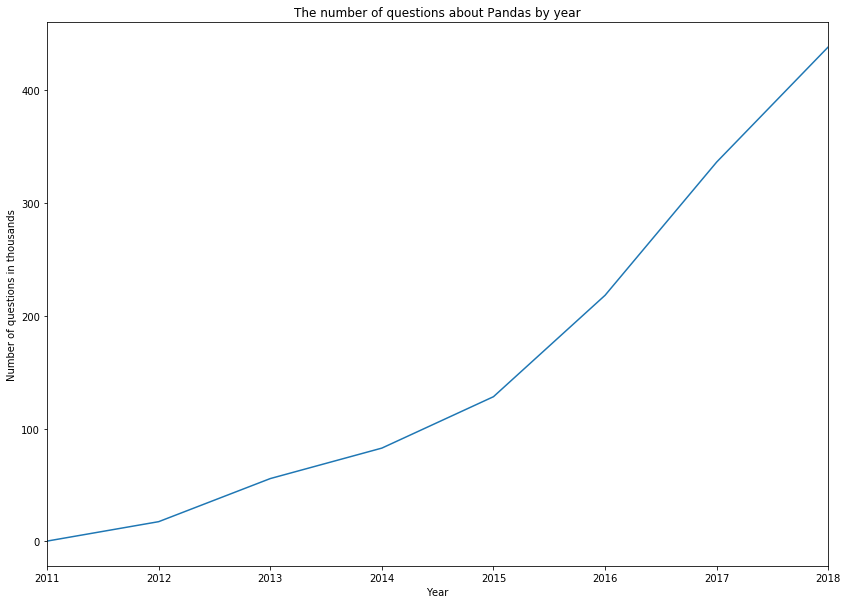

In [0]:
plt.figure(figsize=(14,10))
df5.groupby('Year')['Number_of_Questions'].sum().div(100).plot()
plt.ylabel('Number of questions in thousands')
plt.title('The number of questions about Pandas by year')
plt.show()

We can see that the number of questions related to pandas data manipulation library increased around 40 times  between 2011 and 2018. 

In [0]:
def tag_technology(df):
	technologies=[]
	
	for row in df.tags:
		if 'python' in ''.join(row):
			technologies.append('python')
		elif 'java' in ''.join(row):
			technologies.append('java')
		elif 'javascript' in ''.join(row):
			technologies.append('javascript')
		elif 'c++' in ''.join(row):
			technologies.append('c++')
		elif 'scala' in ''.join(row):
			technologies.append('scala')
		else:
			technologies.append(np.nan)
	df['tags']=technologies
	return df

In [0]:
df6=tag_technology(df5)

TypeError: ignored

In [0]:
df6=df6.dropna()

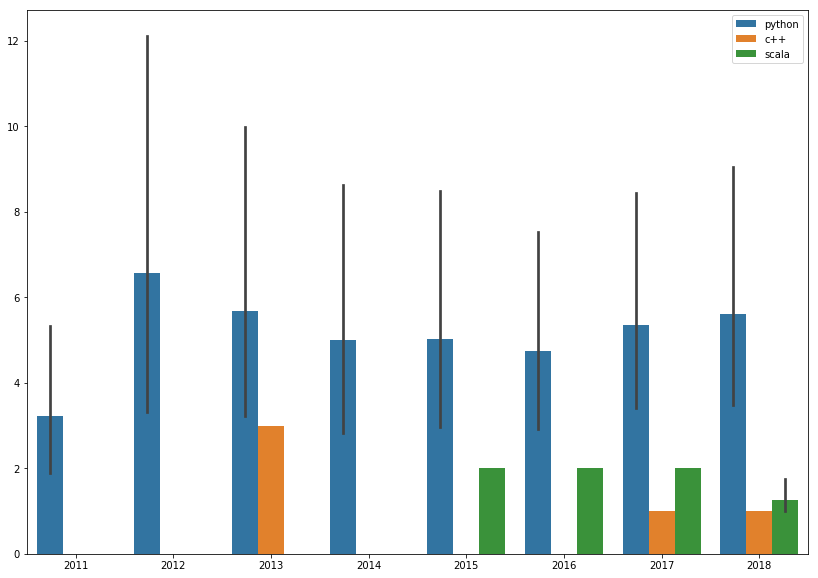

In [0]:
plt.figure(figsize=(14,10))
import seaborn as sns
languages=[t for t in df6.tags]
years=[y for y in df6.Year]
questions=[q for q in df6.Number_of_Questions]

sns.barplot(years,questions,hue=languages)